### Represent the interest pattern by using a simple bipartite graph

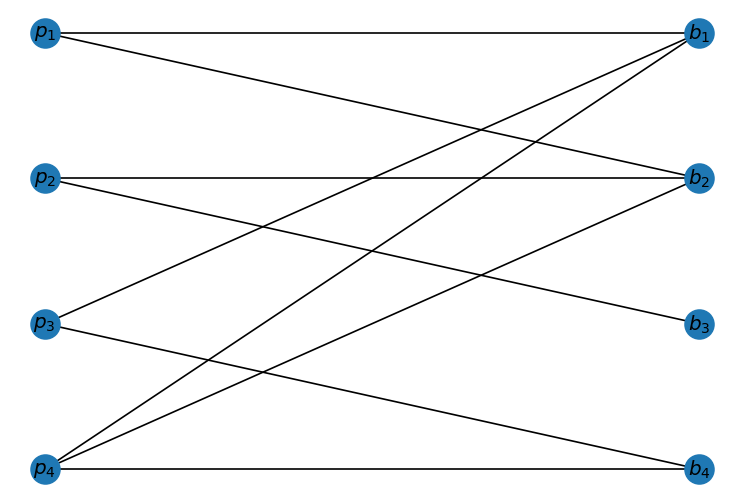

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

interests = {
    'p1': ['b1','b2'],
    'p2': ['b2','b3'],
    'p3': ['b1','b4'],
    'p4': ['b1','b2','b4']
}

# this function is used to write node labels in LaTeX style
def beauty(s):
    return f'${s[0]}_{{{s[1:]}}}$'
interests = {beauty(k):[beauty(v) for v in vv] for k,vv in interests.items()}

# make the undirected bipartite graph to represent the interest pattern
G = nx.Graph()
G.add_edges_from([(k,v) for k,vv in interests.items() for v in vv])

# create disjoint sets of nodes, these will be used also later
V = [[],[]]
V[0] = list(interests.keys())
V[1] = list(set(()).union(*[set(v) for v in interests.values()]))

# set position of nodes in plot
pos = {}
for i in range(2):
    V[i].sort()
    off = max(0,(len(V[1-i])-len(V[i]))/2)
    pos.update({k:[i,-(j+off)] for j,k in enumerate(V[i])})

# plot graph
plt.figure(dpi=120)
nx.draw(G,pos, with_labels=True)
plt.savefig('fig/pattern.png')

### Find a perfect matching

In [2]:
# this function will be used to find required matchings
def match(availabilities, to_assign=1, source='$s$', sink='$t$', problem_image='', solution_image=''):
    # check parameters
    assert len(availabilities) == len(V[1])
    for v in [source, sink]:
        assert v not in list(V[0]+V[1])
    
    # create graph
    DG = nx.DiGraph()
    # add node between disjoint sets V_0 and V_1, capacities are 1 because each person can take only a copy for each book
    DG.add_edges_from([(k,v,{'capacity':1}) for k,vv in interests.items() for v in vv])
    # add source and edges from the source to nodes in V_0, the capacity is set at function call, depending on the request
    DG.add_edges_from([(source,n,{'capacity':to_assign}) for n in V[0]])
    # add sink and edges from nodes in V_1 to the sink, the availabilities are the number of copies of each book
    DG.add_edges_from([(n,sink,{'capacity':c}) for n,c in zip(V[1],availabilities)])
    
    # set the position of source and sink in the plot, pos is taken from previous variables
    h = -(max([len(v) for v in V])-1)/2
    pos.update({source:[-1,h], sink:[2,h]})
    
    # compute maximum flow
    mf = nx.algorithms.flow.maximum_flow(DG,source,sink)
    f = mf[1] # this is the flow vector, in form of a dictionary
    
    # draw labels indicating edge capacity for edges connected to the source or the sink
    plt.figure(dpi=120)
    nx.draw_networkx_edge_labels(
        DG,
        pos,
        #edge_labels={(u,v):str(DG[u][v]['capacity']) for x in [DG.out_edges(source), DG.in_edges(sink)] for u,v in x},
        edge_labels={(u,v):str(DG[u][v]['capacity']) for u,v in DG.edges()},
        font_color='blue',
    )
    
    # draw the graph
    nx.draw(DG,pos, with_labels=True)
    if problem_image != '':
        plt.savefig(f"fig/{problem_image}")
    
    # open another figure to plot the maximum flow
    plt.figure(dpi=120)
    nx.draw_networkx_edge_labels(
        DG,
        pos,
        edge_labels={(u,v):str(DG[u][v]['capacity']) for x in [DG.out_edges(source), DG.in_edges(sink)] for u,v in x},
        #edge_labels={(u,v):str(DG[u][v]['capacity']) for u,v in DG.edges()},
        font_color='blue',
    )
    
    # set color of used edges in the flow to 'red'
    for u in V[0]:
        for v,c in f[u].items():
            if c > 0: DG[u][v]['color'] = 'red'
            #else: 'blue'
    
    # put edge colors in a list, using 'black' as default, and draw the graph
    colors = [DG[u][v].get('color','black') for u,v in DG.edges]
    nx.draw(DG,pos, with_labels=True, edge_color=colors)
    if solution_image != '':
        plt.savefig(f"fig/{solution_image}")
    return DG, mf


The matching is complete


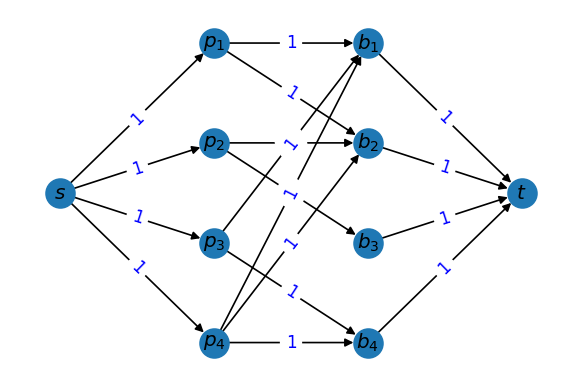

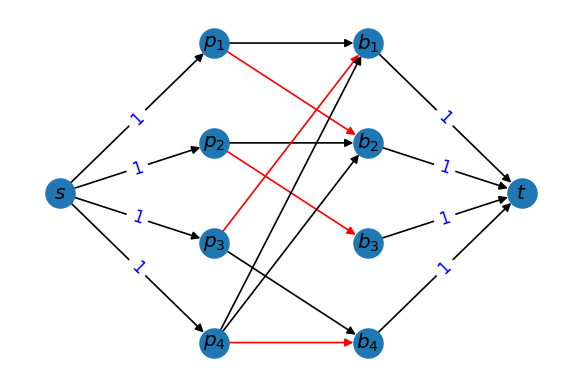

In [3]:
# here we set the capacities of all the edges connected to the source or the sink to 1,
# because we have a copy of each book and each person can take only a book
if match([1,1,1,1], problem_image='match1_prob.png', solution_image='match1_sol.png')[1][0] == len(V[0]):
    print('The matching is complete')
else:
    print('Complete matchings do not exist in this graph')

In the above picture, the edges from nodes in $V_0$ and nodes in $V_1$ have capacity $1$ and the red ones show the match

### Assuming that the number of copies of books are respectively (2, 3, 2, 2) and each person can take only one copy of a given book

In total can be assigned 8 books


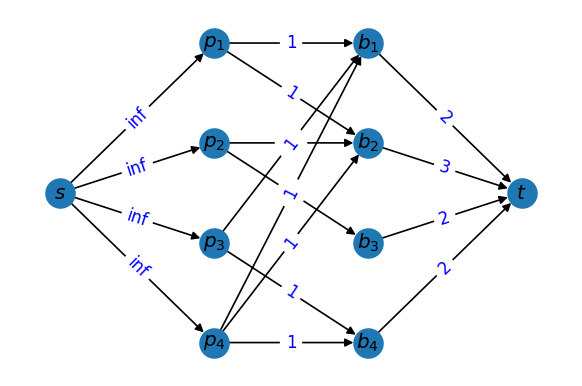

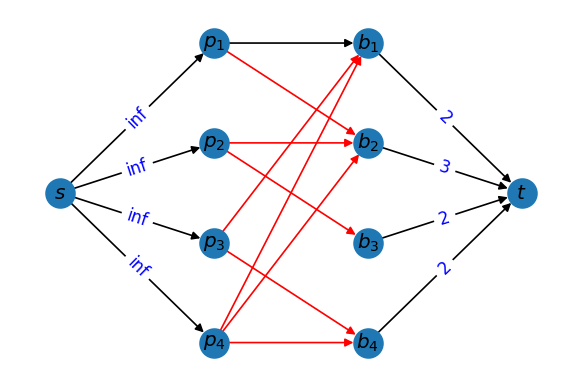

In [4]:
sink = '$t$'
# here we set capacities of edges connected to the source to infinity because each person can take any number of books
DG,mf = match([2,3,2,2],float('inf'),sink=sink, problem_image='match2_prob.png', solution_image='match2_sol.png')
print(f"In total can be assigned {mf[0]} books")

In the above picture, the edges from nodes in $V_0$ and nodes in $V_1$ have capacity $1$ and the red ones show the match

### Suppose that the library can sell a copy of a book and buy a copy of another book. Which books should be sold and bought to maximize the number of assigned books?
We can se from the above picture that there is an unused copy of $b_3$ and that $p_1$ would like to have a copy of $b_1$, but there aren't any left, so the library should sell one copy of $b_3$ and buy one of $b_1$\
The following code retrieves this information.

In [5]:
for u,v in DG.in_edges(sink):
    # compare the number of requests to the book u with the availability of this book
    t = DG.in_degree(u) - DG[u][sink]['capacity']
    if t > 0:
        # in this case we need t copies more
        print(f'The library should buy {t} cop{"y" if t==1 else "ies"} of {u}')
    elif t < 0:
        # in this case we have -t copies unused
        print(f'The library can sell {-t} cop{"y" if -t==1 else "ies"} of {u}')

The library should buy 1 copy of $b_{1}$
The library can sell 1 copy of $b_{3}$
